In [7]:
import torch
import numpy as np
from sgpr import vsgp
from non_positive_definite_fixer import remove_similar_data, compute_inverse_and_log_det_positive_eigen, Gaussian_log_likelihood, train_adam_with_reset
from kernel import ARDKernel
from matplotlib import pyplot as plt
from data_process import data_process
import gp_computation_pack as gp_pack
import torch.nn as nn
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

xtr.size: torch.Size([100, 1]) ytr.size: torch.Size([100, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


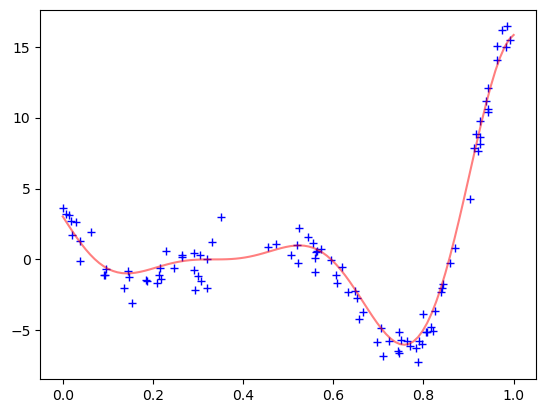

In [12]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

In [40]:
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        
        self.data = data_process(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)
        self.X, self.Y = remove_similar_data(self.X, self.Y) # implement on remove_similar_data in non_positive_definite_fixer
        

        # GP hyperparameters
        self.log_beta = nn.Parameter(torch.ones(1) * 0)   # a large noise by default. Smaller value makes larger noise variance.
        self.log_length_scale = nn.Parameter(torch.zeros(X.size(1)))    # ARD length scale
        self.log_scale = nn.Parameter(torch.zeros(1))   # kernel scale

    # define kernel function
    def kernel(self, X1, X2):
        # the common RBF kernel
        X1 = X1 / self.log_length_scale.exp()
        X2 = X2 / self.log_length_scale.exp()
        # X1_norm2 = X1 * X1
        # X2_norm2 = X2 * X2
        X1_norm2 = torch.sum(X1 * X1, dim=1).view(-1, 1)
        X2_norm2 = torch.sum(X2 * X2, dim=1).view(-1, 1)

        K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(0))  #this is the effective Euclidean distance matrix between X1 and X2.
        K = self.log_scale.exp() * torch.exp(-0.5 * K)
        return K
        
    def forward(self, Xte):
        Xte = self.data.normalize(Xte)
        sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
        self.X.size(0))
        K_xt = self.kernel(self.X, Xte)
        K_tt = self.kernel(Xte,Xte)
        
        mean,var= gp_pack.conditional_Gaussian(self.Y, sigma, K_xt, K_tt)
        var_diag = var.diag().view(-1, 1)
        # de-normalized
        mean, var_diag = self.data.denormalize_result(mean, var_diag)
        return mean, var_diag


    def negative_lower_bound(self):
        K_xx=self.kernel(self.X,self.X)+JITTER * torch.eye(self.X.size(0))
        return -Gaussian_log_likelihood(self.Y, K_xx, Kinv_method='eigen') # implement on eigendecomposition in non_positive_definite_fixer
    

In [44]:
model=cigp(xtr,ytr)
train_adam_with_reset(model, niteration=100)

Removed 92 small or non-positive eigenvalue(s).
Loss: 1845.8565673828125
Removed 92 small or non-positive eigenvalue(s).
Loss: 1634.43798828125
Removed 92 small or non-positive eigenvalue(s).
Loss: 1448.07275390625
Removed 92 small or non-positive eigenvalue(s).
Loss: 1283.7579345703125
Removed 92 small or non-positive eigenvalue(s).
Loss: 1143.1383056640625
Removed 92 small or non-positive eigenvalue(s).
Loss: 1014.0718383789062
Removed 92 small or non-positive eigenvalue(s).
Loss: 904.1297607421875
Removed 92 small or non-positive eigenvalue(s).
Loss: 808.3250732421875
Removed 91 small or non-positive eigenvalue(s).
Loss: 1705.317138671875
Removed 91 small or non-positive eigenvalue(s).
Loss: 1518.6341552734375
Removed 91 small or non-positive eigenvalue(s).
Loss: 1295.9031982421875
Removed 91 small or non-positive eigenvalue(s).
Loss: 1132.9052734375
Removed 91 small or non-positive eigenvalue(s).
Loss: 1002.7759399414062
Removed 91 small or non-positive eigenvalue(s).
Loss: 886.523

torch.Size([100, 1])


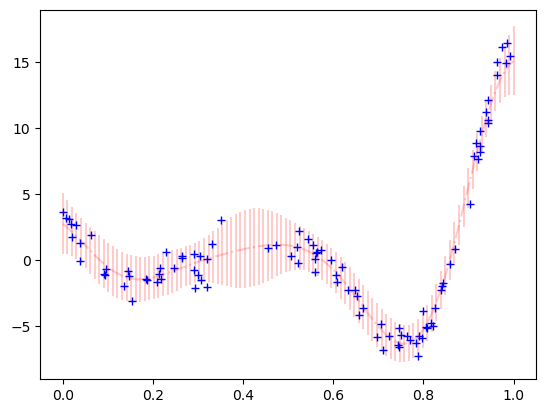

In [45]:
with torch.no_grad():
    ypred, yvar = model.forward(xte)
print(yvar.size())   
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()